# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Author:** Mohammadreza Ebrahimi, Magnin Jean-Baptiste Roger Philippe  
**Due date:** 26.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [11]:
import tarfile
import os
import numpy as np
import pdb
import cv2
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

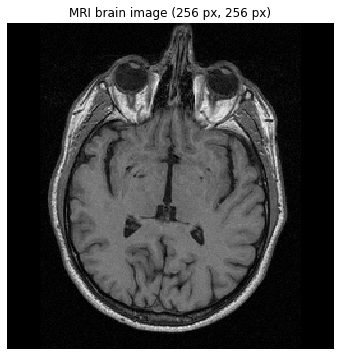

In [12]:
import skimage.io
import matplotlib.pyplot as plt

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### Pre-Processing
Altough this step is not mentioned as a necessary one, it's a good practice to check the effect of pre-processing on the final results. We will apply histogram equilization to check whether more details of the brain can be captured and a gaussian filter for noise removal purposes.

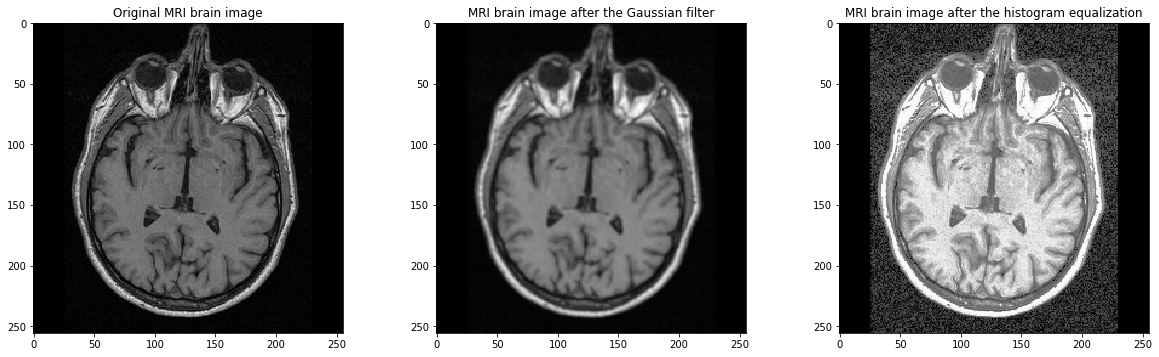

In [30]:
# Performs the median filter based on 3 points
brain_im_gauss = cv2.GaussianBlur(brain_im,(3,3),cv2.BORDER_DEFAULT)

# Performs histogram equalization
brain_im_eqhist= cv2.equalizeHist(brain_im)

titles = ['Original MRI brain image', 'MRI brain image after the Gaussian filter', 'MRI brain image after the histogram equalization']
outputs = [brain_im, brain_im_gauss, brain_im_eqhist]

fig = plt.figure(figsize=(20, 6))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(1,4):
    ax = fig.add_subplot(1, 3, i)
    ax.imshow(outputs[i-1], cmap='gray')
    plt.title(titles[i-1])
plt.show()

### 1.2 Region growing
As introduced in the lectures, region growing is a recursive and relatively convinient approach of finding target segments in an image. For that, we have developed a simple implementation of this idea to find the pixels, corresponding to the brain tissue.
There are some important parameters that should be defined for this algorithm. First, a threshold value based on which neighbor pixles will be assumed to be part of one segmentation or not. Then we need a seed, which is the initial point and should belong to the target segment. Then, recursively, we get to the desired part.

In [7]:
def region_growing(img, ref, thresh):
    # Parameters for region growing
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    neighbor_points_list = []
    final_list = []
    neighbor_points_list.append(ref)

    # Input image parameters
    height, width = img.shape

    # Initialize segmented output image
    segmented_img = np.ones((height, width), np.uint8)
    segmented_img[ref] = 255
    j = 0
    # Region growing until intensity difference becomes greater than certain threshold
    while len(neighbor_points_list) > 0 and j < height*width:
        j += 1
        # Loop through neighbor pixels
        ref = neighbor_points_list[0]
        for i in range(4):
            # Compute the neighbor pixel position
            x_new = ref[0] + neighbors[i][0]
            y_new = ref[1] + neighbors[i][1]

            # Boundary Condition - check if the coordinates are inside the image
            check_inside = (x_new >= 0) & (y_new >= 0) & (x_new < height) & (y_new < width)

            # Add neighbor if inside and not already in segmented_img
            if check_inside:
                if abs(int(img[x_new, y_new]) - int(img[ref[0], ref[1]])) < thresh and [x_new, y_new] not in final_list and [x_new, y_new] not in neighbor_points_list:
                    neighbor_points_list.append([x_new, y_new])
                    segmented_img[x_new, y_new] = 255

        final_list.append(ref)

        # remove already checked point
        neighbor_points_list.pop(0)

    return segmented_img, len(final_list)

In [8]:
seed = (137, 148)
diff = 8
seg_img, total_pixels = region_growing(brain_im, seed, diff)

In [6]:
seed = (100, 100)
diff = 8
seg_img_gauss, tp = region_growing(brain_im_gauss, seed)

The total number of pixels is = 16298


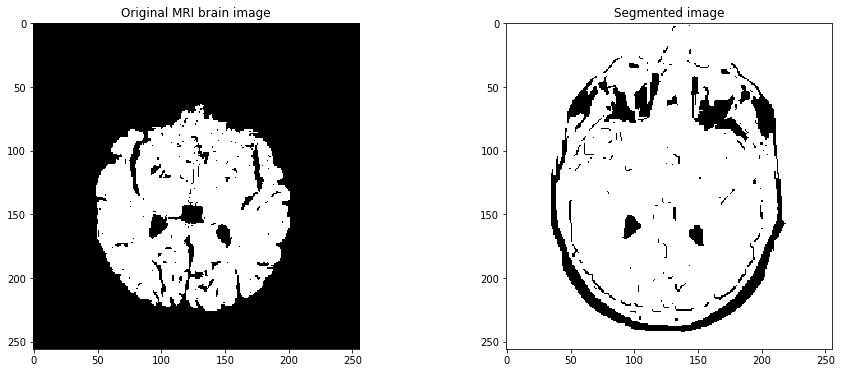

In [9]:
print('The total number of pixels is = ' + str(total_pixels))

titles = ['Region Growing without pre-processing', 'Region Growing with pre-processing']
outputs = [seg_img, seg_img_gauss]

fig = plt.figure(figsize=(15, 6))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(1,3):
    ax = fig.add_subplot(1, 2, i)
    ax.imshow(outputs[i-1], cmap='gray')
    plt.title(titles[i-1])
plt.show()

Based on this result, we observe that in the case we perform pre-processing, we need to use another threshold otherwise, we end up with a totally wrong result. Hence, in the next section, we used another threshold. (specified as diff)

In [19]:
seed = (100, 100)
diff = 4 #changing tje threshold becasue some smoothing has been applied
seg_img_gauss, tp = region_growing(brain_im_gauss, seed, diff)

The total number of pixels is = 16298


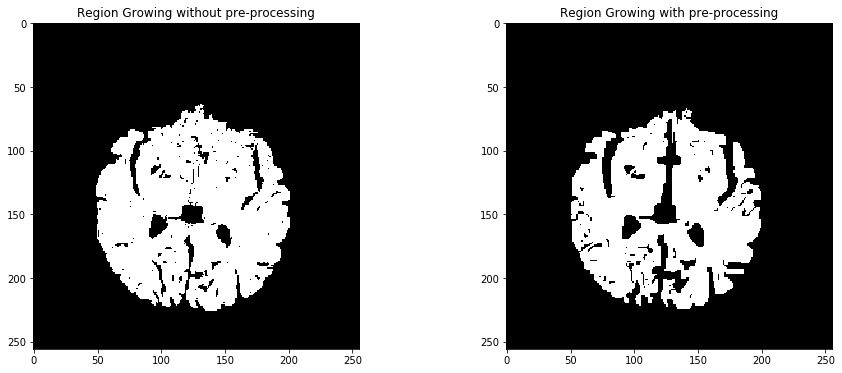

In [24]:
print('The total number of pixels is = ' + str(total_pixels))

titles = ['Region Growing without pre-processing', 'Region Growing with pre-processing']
outputs = [seg_img, seg_img_gauss]

fig = plt.figure(figsize=(15, 6))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(1,3):
    ax = fig.add_subplot(1, 2, i)
    ax.imshow(outputs[i-1], cmap='gray')
    plt.title(titles[i-1])
plt.show()

We can see some improvements by using a gaussian blurring since some areas formerly were taken to belong to the brain, whereas it wasn't the case. So, pre-processing can be useful or destructive, depending on the way we use it.

### 1.3 Contour detection
This part is less straightforward, and it's rather composed of multiple steps. The reason is that these algorithms generally depend on edge detection, and the skull part in the image contains quite a few edges that interfere with the process of separating the brain tissue.

In [13]:
#Sobel , LoG
from scipy import ndimage
from skimage.filters import sobel

brain_im_gauss = cv2.GaussianBlur(brain_im,(5,5),0)

im_log = ndimage.gaussian_laplace(brain_im, sigma=2)
im_sob = sobel(brain_im)

im_gsob = sobel(brain_im_gauss)
im_glog = ndimage.gaussian_laplace(brain_im_gauss, sigma=2)

Mean of Sobel is 0.022521248175536676.


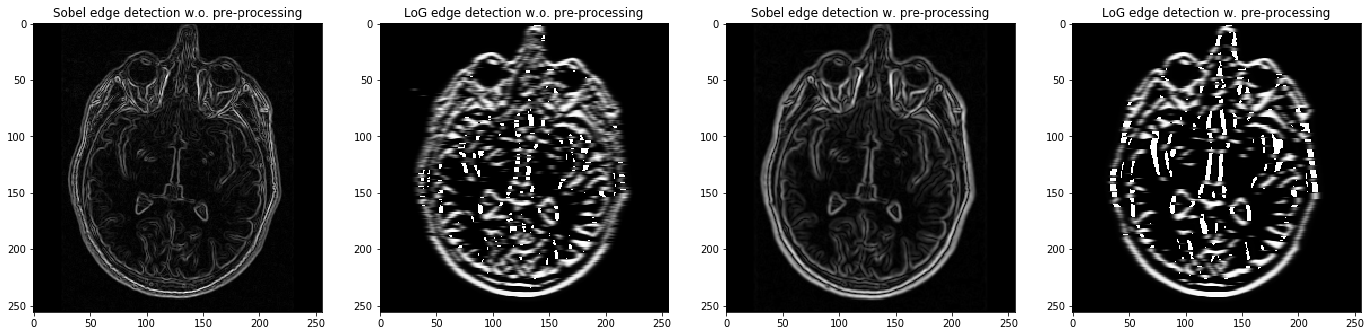

In [14]:
outputs = [im_sob, im_log, im_gsob, im_glog]
fig = plt.figure(figsize=(30, 6))
plt.gray()
titles = ['Sobel edge detection w.o. pre-processing', 'LoG edge detection w.o. pre-processing', 'Sobel edge detection w. pre-processing', 'LoG edge detection w. pre-processing']
print("Mean of Sobel is {}.".format(im_gsob.mean()))

for i in range(1,5):
    ax = fig.add_subplot(1, 5, i)
    ax.imshow(outputs[i-1])
    plt.title(titles[i-1])
plt.show()

We tried both Sobel edge detection and Laplacian of a Gaussian. Based on the results, it seems more reasonable to work with the Sobel filter. Also, it's better to work with the pre-processed version of the image since the edges are smoother and better defined in this case.

After detecting the edges, we should get rid of the ones belonging to the skull. For that, we apply simple thresholding based on the mean of the Sobel image. Then, we fill all the wholes inside the skull to have a uniform white area inside the skull. The reason is that in the case we subtract the initial thresholded image from this new one (called foreground), we can more or less get rid of the extra skull edges. One can find the result of this subtraction.

In [15]:
from skimage.filters import sobel
from scipy.ndimage.morphology import binary_fill_holes

_,binary = cv2.threshold(im_gsob,0.022,255,0)
foreground = binary_fill_holes(binary).astype(np.uint8)

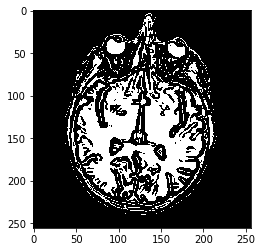

In [16]:
plt.imshow(np.abs(255*foreground - binary))

By getting to this point, we can extract the brain tissue by removing the small objects in the image. Then, as it is observable, the extracted segment is quite pouros and small. Therefore, we applied two iterations of dilation with a 2 by 2 kernel to get closer to the original brain tissue. The final result seems to be fine being aware of the necessary steps associated with contour detection of this particular case.

In [17]:
from skimage import morphology
brain_tissue = morphology.remove_small_objects((foreground*255-binary).astype(bool), min_size=500)

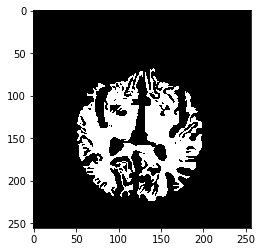

In [18]:
plt.imshow(brain_tissue)

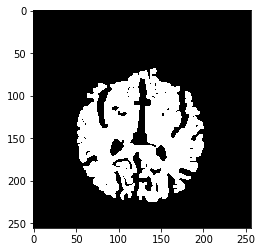

In [19]:
kernel = np.ones((2,2),np.uint8)
brain_final = cv2.dilate(brain_tissue.astype(np.uint8),kernel,iterations=2)
plt.imshow(brain_final)

The total number of pixels is = 14070
Mean of Sobel is 0.022521248175536676.


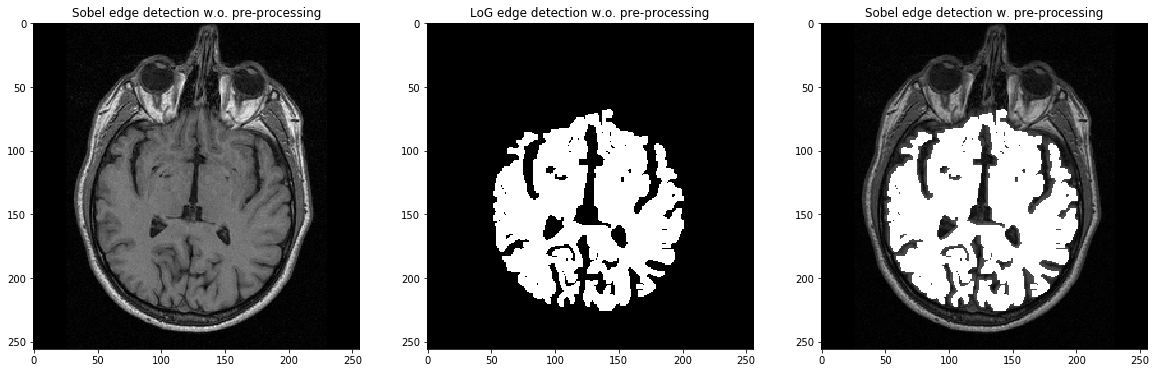

In [27]:
print('The total number of pixels is = ' + str(np.sum(brain_final)))
superimposed = (brain_final*255) | brain_im 
images = [brain_im, brain_final, superimposed]
fig = plt.figure(figsize=(20, 6))
plt.gray()
titles = ['Sobel edge detection w.o. pre-processing', 'LoG edge detection w.o. pre-processing', 'Sobel edge detection w. pre-processing', 'LoG edge detection w. pre-processing']
print("Mean of Sobel is {}.".format(im_gsob.mean()))

for i in range(1,4):
    ax = fig.add_subplot(1, 3, i)
    ax.imshow(images[i-1])
    plt.title(titles[i-1])
plt.show()

### 1.4 Additional method(s)
Add your implementation and discussion

For this part, we work with thresholding in order to separate the brain tissue. As the contour detection section, this method is not that straightforward as well. The reason is that the pixel values of some parts of the skull are quite close to that of the brain tissue. Fortunately, most parts of the skull are brighter than the brain. For this reason, we can apply the thresholding twice with different values, and then by subtraction, we should be able to take out the brain part with some more post-processing.

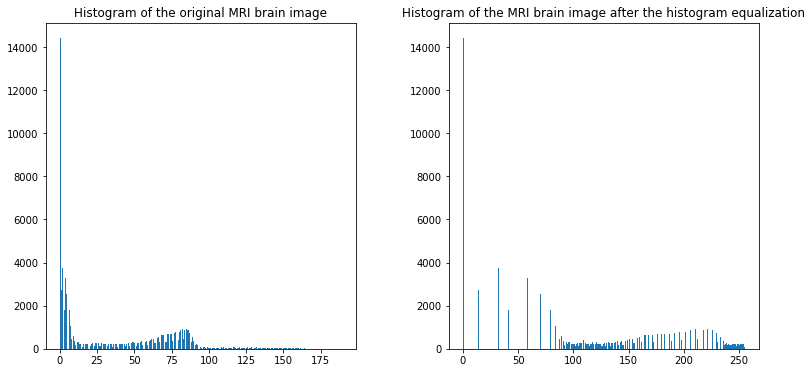

In [31]:
titles = ['Histogram of the original MRI brain image', 'Histogram of the MRI brain image after the histogram equalization']
outputs = [brain_im, brain_im_eqhist]

fig = plt.figure(figsize=(20, 6))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(1,3):
    ax = fig.add_subplot(1, 3, i)
    ax.hist(outputs[i-1].ravel(), bins=256)
    plt.title(titles[i-1])
plt.show()

In [32]:
from skimage.morphology import square

# Finding all the white areas using a binary thresholding on equalized histogram image
_,binary= cv2.threshold(brain_im_eqhist,155,255,cv2.THRESH_BINARY)

# Finding the white areas which are not a part of brain
# Using a binary thresholding on equalized histogram image
_,skull= cv2.threshold(brain_im_eqhist,240,255,cv2.THRESH_BINARY)

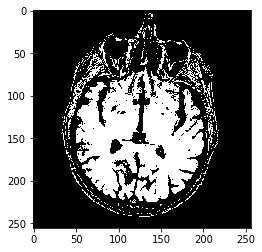

In [33]:
#adaptive
plt.imshow(skull - binary)

This is the result of the case that we use these specific values (155, 240) for thresholds. We will show that in the situation, we choose different values from 155 and 240, the result of this subtraction will be changed, and therefore the post-processing step varies accordingly. For the current image, we need morphology to get to the brain tissue. Hence, we performed an opening on this image to get to the one after.

As you one can notice, some small objects should be removed so that we get to the final result.

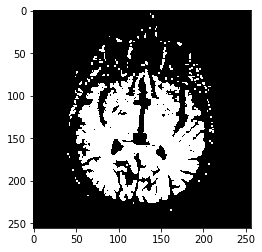

In [34]:
kernel = np.ones((2,2),np.uint8)
res = skull - binary
opening = cv2.morphologyEx(res, cv2.MORPH_OPEN, kernel)
plt.imshow(opening)

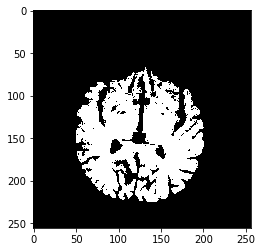

In [35]:
brain_tissue = skimage.morphology.remove_small_objects(res.astype(bool), min_size=200)
plt.imshow(brain_tissue)

The total number of pixels is = 14214
Mean of Sobel is 0.022521248175536676.


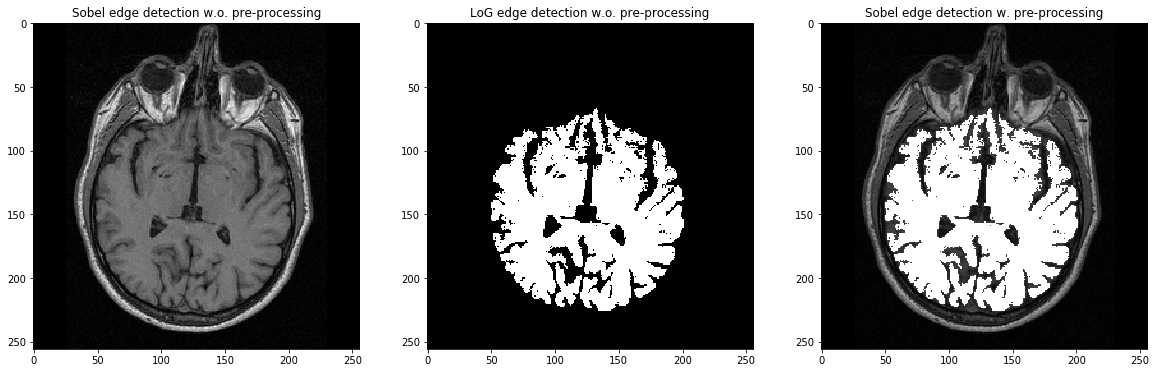

In [36]:
print('The total number of pixels is = ' + str(np.sum(brain_tissue)))
superimposed = (brain_tissue*255) | brain_im 
images = [brain_im, brain_tissue, superimposed]
fig = plt.figure(figsize=(20, 6))
plt.gray()
titles = ['Sobel edge detection w.o. pre-processing', 'LoG edge detection w.o. pre-processing', 'Sobel edge detection w. pre-processing', 'LoG edge detection w. pre-processing']
print("Mean of Sobel is {}.".format(im_gsob.mean()))

for i in range(1,4):
    ax = fig.add_subplot(1, 3, i)
    ax.imshow(images[i-1])
    plt.title(titles[i-1])
plt.show()

Now, we want to change the mentioned thresholds to achieve a different result. This time, we use 155 and 230, and this small change will lead to totally different behavior. After performing the same steps, the resulting image will be the following one. By just changing 240 to 230, we are removing more parts of the brain tissue compared to the former situation. Hence a dilation after this step can lead us to the final result.

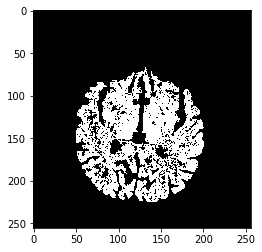

In [39]:
_,binary= cv2.threshold(brain_im_eqhist,155,255,cv2.THRESH_BINARY)

# Finding the white areas which are not a part of brain
# Using a binary thresholding on equalized histogram image
_,skull= cv2.threshold(brain_im_eqhist,230,255,cv2.THRESH_BINARY)
plt.imshow(skull - binary)
kernel = np.ones((2,2),np.uint8)
res = skull - binary
no_skull = skimage.morphology.remove_small_objects(res.astype(bool), min_size=100)
plt.imshow(no_skull)

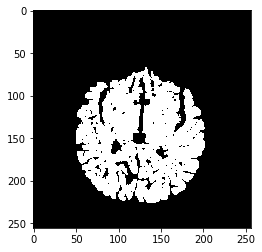

In [40]:
closing = cv2.dilate(no_skull.astype(np.uint8), kernel, iterations=1)
plt.imshow(closing)

The total number of pixels is = 15675
Mean of Sobel is 0.022521248175536676.


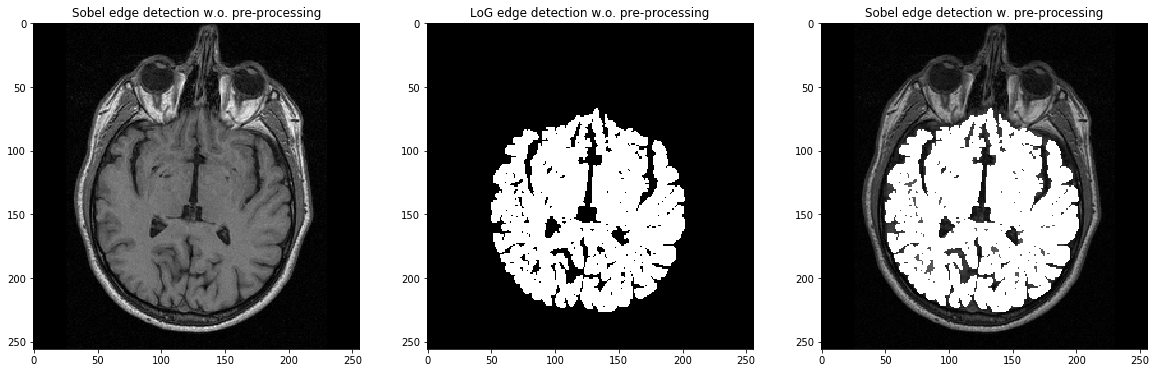

In [41]:
print('The total number of pixels is = ' + str(np.sum(closing)))
superimposed = (closing*255) | brain_im 
images = [brain_im, closing, superimposed]
fig = plt.figure(figsize=(20, 6))
plt.gray()
titles = ['Sobel edge detection w.o. pre-processing', 'LoG edge detection w.o. pre-processing', 'Sobel edge detection w. pre-processing', 'LoG edge detection w. pre-processing']
print("Mean of Sobel is {}.".format(im_gsob.mean()))

for i in range(1,4):
    ax = fig.add_subplot(1, 3, i)
    ax.imshow(images[i-1])
    plt.title(titles[i-1])
plt.show()

We can see that we achieved slightly better segmentation. This comparison provides some vision on the whole case of approach selection to find the desired region. With this method, we finish up with the extracting brain tissue of this Lab

## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### 2.1 Visualization

In [3]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


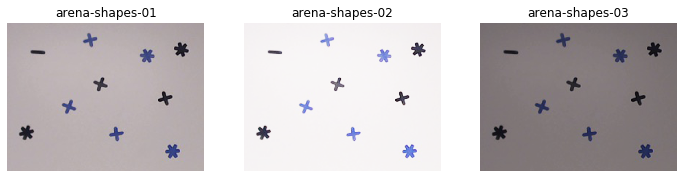

In [4]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color
Add your implementation and discussion

In [5]:
import numpy as np
import pylab

First lets plot the histograms of the three images. We plot the histogram of the colour images converted to grey-scale by taking the mean over the three colour channels.

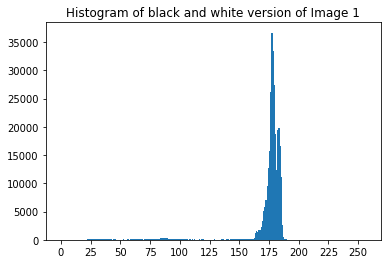

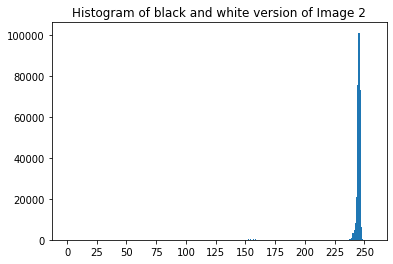

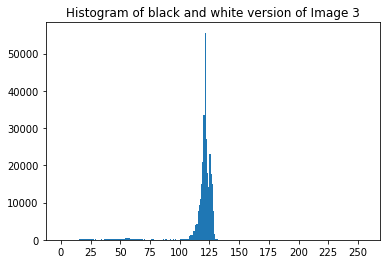

In [6]:
#plot of grey_scale histograms

mean = np.mean(images[0,:,:,:], axis=2)
ax = plt.hist(mean.ravel(),bins=256, range=[0,256])
pylab.xticks(range(0,275,25))
plt.title('Histogram of black and white version of Image 1')
plt.show()

mean = np.mean(images[1,:,:,:], axis=2)
ax = plt.hist(mean.ravel(),bins=256, range=[0,256])
pylab.xticks(range(0,275,25))
plt.title('Histogram of black and white version of Image 2')
plt.show()

mean = np.mean(images[2,:,:,:], axis=2)
ax = plt.hist(mean.ravel(),bins=256, range=[0,256])
pylab.xticks(range(0,275,25))
plt.title('Histogram of black and white version of Image 3')
plt.show()

Looking at the three histograms, it appears that it would be hard to find one threshold to remove the uniform background in the three cases, the three images should be normalized.

So let's try to set the three images to the same illumination, to be more robust. To do this we try to simply offset every value of pixels of each color channel by a same value. We decided to choose to bring the second and third image to the illumination of the first one, as it was a middle ground between them. So we compute the mean value of each channel of image 1, and substract to the two other the differences between their mean and the means of image 1. We had to cast the pixels in int16 from uint8, in order to manually bound the pixel values between 0 and 255.

In [7]:
#mean of channels of image 1, for reference, we could also choose another image as reference, this code would still work
means_ch = np.zeros((3))
for nb_ch in range(3):
    means_ch[nb_ch] = np.mean(images[0,:,:,nb_ch])
print(means_ch)

#function to change illumination of the image, using the mean computed before
def normalize_image(im, means_ch):
    r_im = im.astype('int16')
    for nb_ch in range(3):
        r_im[:,:,nb_ch] = r_im[:,:,nb_ch] - (np.mean(r_im[:,:,nb_ch]) - means_ch[nb_ch])
        r_im[r_im[:,:,nb_ch] >= 256, nb_ch] = 255
        r_im[r_im[:,:,nb_ch] < 0, nb_ch] = 0
    r_im = r_im.astype('uint8')
    return r_im

[179.98862956 170.4091569  173.06199219]


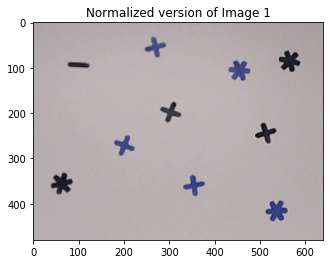

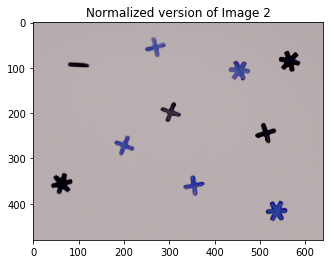

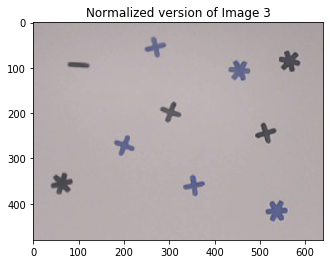

In [8]:
#compute normalized images and print them
im1=normalize_image(images[0,:,:,:],means_ch)
a1=plt.imshow(im1)
plt.title('Normalized version of Image 1')
plt.show()
im2=normalize_image(images[1,:,:,:],means_ch)
a2=plt.imshow(im2)
plt.title('Normalized version of Image 2')
plt.show()
im3=normalize_image(images[2,:,:,:],means_ch)
a3=plt.imshow(im3)
plt.title('Normalized version of Image 3')
plt.show()

Observing the images normalized using the previously explained method, it appears that it was more or less effective. Indeed, it did bring the general illumination to similar rendering, the background appear almost similar, but the objects remain different. One advantage of doing this is that the thresholding valued to remove the background should now be very similar between the three images. It probably cannot get much better, because when an image's luminosity is reduced, information is loss that can be recovered (dark pixels that cannot decrease to a value inferior to zero, and the opposite for bright pixels)
Let's print the histograms again to verify that it was effective. 

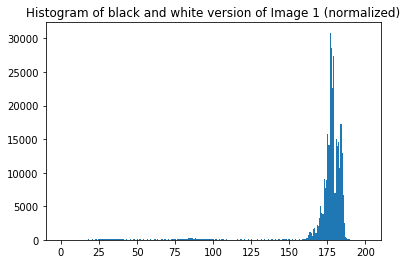

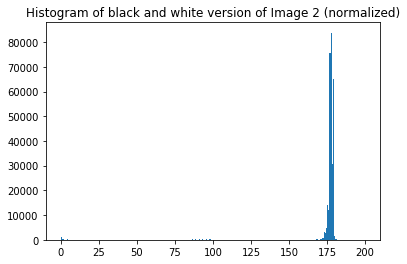

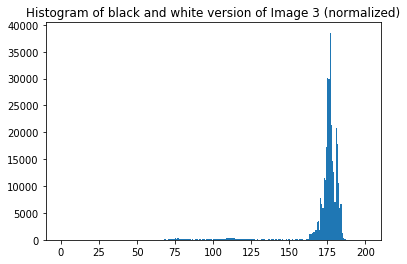

In [9]:
#plot of grey_scale histograms AFTER normalization
mean1 = np.mean(im1, axis=2)
ax = plt.hist(mean1.ravel(),bins=256, range=[0,200])
pylab.xticks(range(0,225,25))
plt.title('Histogram of black and white version of Image 1 (normalized)')
#plt.yscale('log')
plt.show()

mean2 = np.mean(im2, axis=2)
ax = plt.hist(mean2.ravel(),bins=256, range=[0,200])
pylab.xticks(range(0,225,25))
plt.title('Histogram of black and white version of Image 2 (normalized)')
#plt.yscale('log')
plt.show()

mean3 = np.mean(im3, axis=2)
ax = plt.hist(mean3.ravel(),bins=256, range=[0,200])
pylab.xticks(range(0,225,25))
plt.title('Histogram of black and white version of Image 3 (normalized)')
#plt.yscale('log')
plt.show()

The peak representing the background is now centered on almost the same value for the three images, we can thus remove the background using the same threshold. We choose 140 as threshold value. All the pixel with value over 140 ar set to 255 (using the grey scale version, e.g the mean over the three colour channels). 

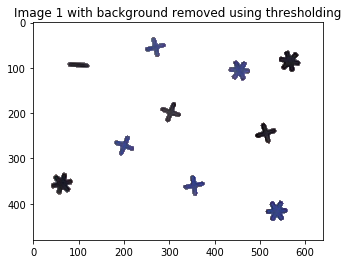

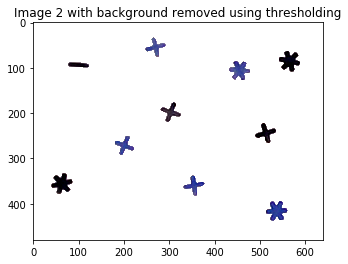

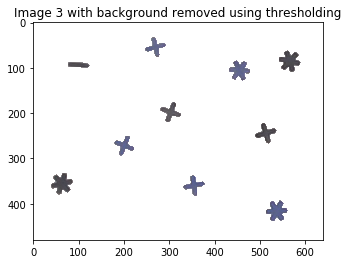

In [10]:
#threshold background
mean1[mean1>140] = 255 
im1[mean1==255,:] = 255
a4=plt.imshow(im1)
plt.title('Image 1 with background removed using thresholding')
plt.show()

mean2[mean2>140] = 255 
im2[mean2==255,:] = 255
a4=plt.imshow(im2)
plt.title('Image 2 with background removed using thresholding')
plt.show()

mean3[mean3>140] = 255 
im3[mean3==255,:] = 255
a4=plt.imshow(im3)
plt.title('Image 3 with background removed using thresholding')
plt.show()

The background appears to be removed correctly.

The next step is to try to separate each shape from each other. The following method is used:

- we use the grey scale image (the mean over the three channels) with backgroud set to 255
- we loop through each of its pixel
- when the value of the current pixel is 255, nothing is done
- else, we give it a label, either a new one, or the one of its neighbours if they are already labeled

In the end, every pixel of each object should have the same label, different for each object. Changing the paramter 'size' in the function 'get_neighbour_coord' allows to change the number of neighbours that are considered. After some experiments, it appears  that it works best when each pixel can get the label of the pixels in a 10-pixel radius. 
This works quite well in this case, because the different objects are quite far appart from each others.

In [11]:
#separate each shape

#functions that returns a bool array with True values at the pixels a radius of size-pixels around pixel with coordinate (line, col)
def get_neighbours_coord(line, col, size, shape):
    neighb = np.zeros(shape, dtype=bool)
    neighb[(line-size):(line+size+1), (col-size):(col+size+1)] = True
    return neighb
    
    
#function to count object in a grey_scale image, with removed background
def count_objects(image):
    shape_num = 1
    label = np.zeros(image.shape)
    for lines in range(image.shape[0]):
        for cols in range(image.shape[1]):
            if image[lines, cols] == 255:
                continue
            neighb = get_neighbours_coord(lines, cols, 10, image.shape)
            if np.any(image[neighb] != 255):
                if label[neighb].max() == 0:
                    label[np.logical_and(image != 255, neighb)] = shape_num
                    shape_num = shape_num + 1
                else:
                    label[np.logical_and(image != 255, neighb)] = label[neighb].max()
    return label
                    
            


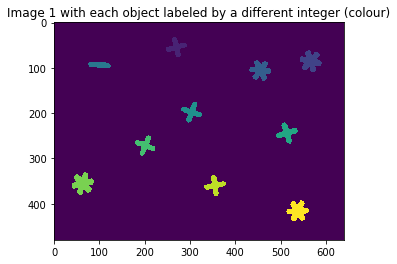

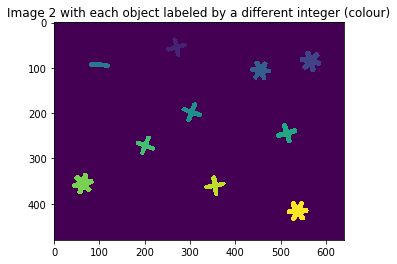

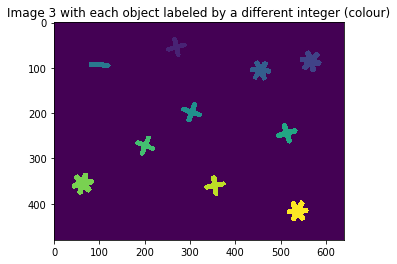

In [12]:
label1 = count_objects(mean1)
a=plt.imshow(label1)
plt.title('Image 1 with each object labeled by a different integer (colour)')
plt.show()

label2 = count_objects(mean2)
a=plt.imshow(label2)
plt.title('Image 2 with each object labeled by a different integer (colour)')
plt.show()

label3 = count_objects(mean3)
a=plt.imshow(label3)
plt.title('Image 3 with each object labeled by a different integer (colour)')
plt.show()

We now have all the objects separated from each other, each have a different label in the labelx arrays. It is now easy to determine their colour, the number of pixel composing them, as well as their shape:

- for their colour: look at the mean value of each object in the blue channel, a threshold should be easily found
- for their shape: maybe a little harder, separate them according to the number of pixel composing each shape, should be (-)<(+)<(*)
- then simply count the pixels

To find the right threshold, it could be interesting to plot each object in a graph mean_value vs number_of_pixels:

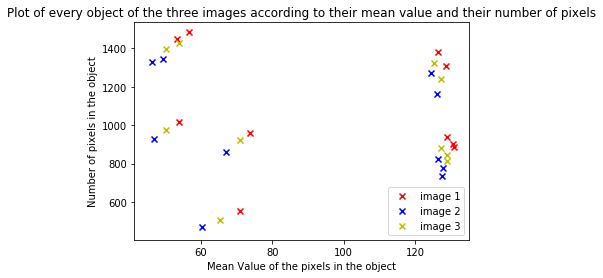

In [19]:
#Determine colour and class of each shape

def get_colour_and_count(image, label):
    nb_pix = np.zeros([1,int(label.max())])
    mean_value = np.zeros([1,int(label.max())])
    for i in range(1, int(label.max())+1):
        #check in blue channel
        nb_pix[0,i-1] = im1[label==i,2].shape[0]
        mean_value[0,i-1] = np.mean(im1[label==i,2])
    return nb_pix, mean_value

nb1, mean_val1 = get_colour_and_count(im1, label1)
nb2, mean_val2 = get_colour_and_count(im2, label2)
nb3, mean_val3 = get_colour_and_count(im3, label3)


fig, ax = plt.subplots()
ax.scatter(mean_val1, nb1, marker='x', color='r', label="image 1")
ax.scatter(mean_val2, nb2, marker='x', color='b', label="image 2")
ax.scatter(mean_val3, nb3, marker='x', color='y', label="image 3")
ax.set_xlabel("Mean Value of the pixels in the object")
ax.set_ylabel("Number of pixels in the object")
plt.legend(loc=0)
ax.set_title('Plot of every object of the three images according to their mean value and their number of pixels')
plt.show()

Observing this plot, it appears easy to separate each object according to its colour:
- mean value > 90 -> blue
- mean value < 90 -> black

Shape is a little more complicated, but still feasible:
- number of pixels > 1100 -> '*'
- number of pixels < 650 -> '-'
- else -> '+'

So let's now solve the original problem, the number of shape of each colour:

In [14]:
def print_number_of_shape_of_each_colour(num_pix, mean_val):
    nb_blue = np.sum(mean_val > 90)
    nb_black = np.sum(mean_val < 90)
    nb_blue_cross = np.sum(np.logical_and(mean_val > 90, np.logical_and(num_pix>650, num_pix<1100)))
    nb_blue_star = np.sum(np.logical_and(mean_val > 90, num_pix>1100))
    nb_blue_minus = np.sum(np.logical_and(mean_val > 90, num_pix<650))
    nb_black_cross = np.sum(np.logical_and(mean_val < 90, np.logical_and(num_pix>650, num_pix<1100)))
    nb_black_star = np.sum(np.logical_and(mean_val < 90, num_pix>1100))
    nb_black_minus = np.sum(np.logical_and(mean_val < 90, num_pix<650))
    answer = "There is {} blue objects, {} black objects, {} blue cross, {} blue star, {} blue minus, {} black cross, {} black star, {} black minus"
    print(answer.format(nb_blue, nb_black, nb_blue_cross, nb_blue_star, nb_blue_minus, nb_black_cross, nb_black_star, nb_black_minus))
    return nb_blue, nb_black

print("For image 1:")
print_number_of_shape_of_each_colour(nb1, mean_val1)
print("For image 2:")
print_number_of_shape_of_each_colour(nb2, mean_val2)
print("For image 3:")
print_number_of_shape_of_each_colour(nb3, mean_val3)
    

For image 1:
There is 5 blue objects, 5 black objects, 3 blue cross, 2 blue star, 0 blue minus, 2 black cross, 2 black star, 1 black minus
For image 2:
There is 5 blue objects, 5 black objects, 3 blue cross, 2 blue star, 0 blue minus, 2 black cross, 2 black star, 1 black minus
For image 3:
There is 5 blue objects, 5 black objects, 3 blue cross, 2 blue star, 0 blue minus, 2 black cross, 2 black star, 1 black minus


(5, 5)

The results are correct for the three images

### 2.3 Total area (in pixels) of each color
Add your implementation and discussion

In [15]:
def area_of_each_color(num_pix, mean_value):
    nb_pix_black = np.sum(num_pix[mean_value < 90])
    nb_pix_blue = np.sum(num_pix[mean_value > 90])
    answer = "There is {} blue pixels and {} black pixels"
    print(answer.format(nb_pix_blue, nb_pix_black))
    return nb_pix_blue, nb_pix_black
 
print("For image 1:")
area_of_each_color(nb1, mean_val1)
print("For image 2:")
area_of_each_color(nb2, mean_val2)
print("For image 3:")
area_of_each_color(nb3, mean_val3)

For image 1:
There is 5413.0 blue pixels and 5459.0 black pixels
For image 2:
There is 4773.0 blue pixels and 4930.0 black pixels
For image 3:
There is 5109.0 blue pixels and 5231.0 black pixels


(5109.0, 5231.0)

The result are similar for the three images, but not exactly identical, some work could probably still be done to obtain a more precise result.

Finally, let's create a routine that, given a color image, re-uses everything explained before to directly answer the questions:

In [20]:
#function that, given a colour image, return the number of blue objects, the number of black objects, the number of blue pixels, the number of black pixels  
def count_objects_and_area(image):
    #hard_coded reference to normalize image TO BE IMPROVED
    ref = np.array([179.98862956, 170.4091569, 173.06199219])

    #normalize image
    im_normalized = normalize_image(image, ref)

    #compute bw image (mean)
    im_bw = np.mean(im_normalized, axis=2)

    #remove background with at hard-coded threshold TO BE IMPROVED
    threshold = 140
    im_bw[im_bw>threshold] = 255

    #detect every object
    label = count_objects(im_bw)

    #analyse objects
    nb_pixels, mean_value = get_colour_and_count(image, label)
    
    #count them and print answer
    nb_blue, nb_black = print_number_of_shape_of_each_colour(nb_pixels, mean_value)

    #find area and print answer
    area_blue, area_black = area_of_each_color(nb_pixels, mean_value)

    return nb_blue, nb_black, area_blue, area_black
    

In [21]:
result = count_objects_and_area(images[0,:,:,:])

There is 5 blue objects, 5 black objects, 3 blue cross, 2 blue star, 0 blue minus, 2 black cross, 2 black star, 1 black minus
There is 5423.0 blue pixels and 5464.0 black pixels
